In [1]:
#import the modules we will need
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from numba import jit
from tqdm.notebook import tqdm


In [2]:
def calcExpK(delta):
    return [[np.cosh(delta),np.sinh(delta)],[np.sinh(delta),np.cosh(delta)]]

In [3]:
def Mphi(phi, expk, nt):
    """
    Function that updates the Fermion matrix
    
    INPUT:
            phi - phi field (array)
            k - hopping parameter (array)
            nt - number of time steps
                        
    OUTPUT:
            M - fermion matrix (update M) 
            
            This uses space index fastest (like Isle)
    """
    n = len(phi)
    nx = int(n/nt)
    if n == M.shape[0]: # this tests if the phi array has the right dimensions
        for t in range(nt-1): # loop over time bloks
            for x in range(nx): # loop over cords and kappa matrix
                M[t*nx+x][t*nx+x] = 1.0 + 0j # diagonal term
                for y in range(nx): # run over the kappa matrix
                    M[(t+1)*nx+x][t*nx+y] = -expk[x][y]*np.exp(1j*phi[t*nx+y]) # off-diagonal
        for x in range(nx): 
            M[(nt-1)*nx+x][(nt-1)*nx+x] = 1.0+0j # diagonal term
            for y in range(nx): # anti-periodic boundary condition
                M[x][(nt-1)*nx+y] = expk[x][y]*np.exp(1j*phi[(nt-1)*nx+y])
        return 0
    else:
        print('# Error! phi and M have inconsistent dimensions!')
        return -1

In [4]:
# this routine calculates det(M[phi]M[-phi])
def calcLogDetMM(phi, expk, nt):
    """
    Function that calculates the determinant of Fermion matrices
    
    INPUT:
            phi - phi field (array)
            expk - exponential of hopping parameter (array)
            Nt - number of time steps
                        
    OUTPUT:
            detMM - determinant of the matrices
    """
    
    Mphi(phi, expk, nt) # update M with +1 phi
    detMM = np.log(np.linalg.det(M)) # calc detM with +1 phi
    Mphi(-np.array(phi), expk, nt) # update M with -1 phi
    detMM += np.log(np.linalg.det(M)) # calc detM with -1 phi
    return detMM

In [5]:
def calcTrMM(phi, expk, nt, sign):
    """
    Function that calculates the trace of a Fermion matrix
    
    INPUT:
            phi - phi field (array)
            expk - exponential of hopping term (array)
            nt - number of time steps
            sign - sign of phi (+1 / -1)
                        
    OUTPUT:
            TrMM - trace of the matrix
    """
    TrMM = [] # trace container
    n = len(phi)
    nx = int(n/nt)
    Mphi(phi, expk, nt) # update M
    invM = np.linalg.inv(M)  # only need to invert once!
    for t in range(nt-1): # loop over time blocks
        for x in range(nx): # loop over sites  (space is fastest)
            temp = 0 + 0j
            for y in range(nx):
                temp += invM[t*nx+x][(t+1)*nx+y]*expk[y][x]
            TrMM.append(temp*(-sign*1j*np.exp(1j*phi[t*nx+x])))
    for x in range(nx): # anti-periodic boundry conditions
        temp = 0 + 0j
        for y in range(nx):
            temp += invM[(nt-1)*nx+x][y]*expk[y][x]
        TrMM.append(temp*sign*1j*np.exp(1j*phi[(nt-1)*nx+x]))

    return np.array(TrMM)

In [6]:
def artH(p, phi, expk, nt, U):
    """
    Function that calculates the artificial Hamiltonian of the Hubbard model
    
    INPUT:
            p - conjugate momentum (array)
            phi - phi field (array)            
            expk - exponential of hopping array (array)
            Nt - number of timesteps
            U - onsite coupling (reduced quantity = U * delta)
            
            (optional)
            beta = inverse temperature
                        
    OUTPUT:
            H - artificial Hamiltonian
    """
        
    H = .5*(np.array(p)@np.array(p)+np.array(phi)@np.array(phi)/U) 
    
    H -= np.real(calcLogDetMM(phi, expk, nt))
    return H

In [7]:
def gradS(phi,U,Nt):
    return phi/U - 2*np.real(calcTrMM(phi,expk,Nt,1))

In [99]:
def ribbit(p, phi, expk, nt, U, Nmd, surrogate, trajLength = 1.):
    """
    Molecular dynamics integrator (Leap frog algorithm)
    
    INPUT:
            p - conjugate momentum (array)
            phi - phi field (array)
            expk - exponential of hopping parameter (array)
            nt - number of timesteps
            Nmd - number of trajectory pieces
            U - onsite coupling
            surrogate - NN trained gradient
            (optional)
            trajLength - length of trajectory
            
    OUTPUT:
            (p, phi) - after integration
    """    
    # python passes variables via "pass by object"
    # need to define new arrays, otherwise the original arrays will change themselves during this call!
    p = np.array([p[i] for i in range(len(p))])
    phi = np.array([phi[i] for i in range(len(phi))])
    if surrogate == None:
        eps = trajLength/Nmd # integration step
    else:
        eps = 0.01
    
    phi += 0.5*eps*p # first half step
    
    # (N - 1) steps of integration
    L = int(np.random.uniform(0, 1)* Nmd)
    for _ in range(L):
        if surrogate == None:
            p -= eps*gradS(phi,U,nt) 
        else:
            p -= eps*surrogate.gradient(phi)  #<====== replace with NN
        phi += eps*p

    # last half step
    if surrogate == None:
        p -= eps*gradS(phi,U,nt) 
    else:
        p -= eps*surrogate.gradient(phi)     #<====== replace with NN
    phi += 0.5*eps*p
    
    return p, phi

In [9]:
# initialize constants for the functions
U=2. # spin coupling
beta=4. # inverse temperature
Nt=16 # number of time steps
Nx = 2 # number of sites
delta = beta/Nt
usqrt = np.sqrt(delta*U) #reduced U

M = np.identity(Nt*Nx) + 0j # (Nt*Ni) x (Nt*Ni) identity matrix
expk = calcExpK(delta) # calc exp(kappa)

Nmd = 10 # 3-5 for best acceptance >= 70%
nTrajs = 2000 # number of auxiliary fields in the ensemble





def HMC(surrogate):
    prob = [] # stores probability
    ensemble = []  # store the individual configurations here
    # sample phi from normal distribution with sigma = sqrt(u)
    phi = np.array([np.random.normal(0,usqrt) for i in range(Nt*Nx)])
    g = np.zeros((nTrajs,Nt*Nx))
    pp = np.zeros((nTrajs,Nt*Nx))
    # loop that generates the ensamble of phis
    for traj in tqdm(range(nTrajs)):
        # sample momentum from normal distribution w/ sigma = 1
        initP = np.array([np.random.normal(0,1) for i in range(Nt*Nx)])

        initPhi = phi #[-Nt*Nx:] # initial Phi
        initH = artH(initP, initPhi, expk, Nt, U*delta) # initial Hamiltonian

        finP, finPhi = ribbit(initP, initPhi, expk, Nt, U*delta, Nmd,surrogate) # final momentum and phi
     
        finH = artH(finP, finPhi, expk, Nt, U*delta) # final hamiltonian
        
        if surrogate is None:
            g[traj,:] = gradS(finPhi,U,Nt)           
        else:
            g[traj,:] = surrogate.gradient(finPhi)
        pp[traj,:] = finPhi
        # accept/reject step
        if np.random.uniform(0,1) <= np.exp(-(finH-initH)): # accept
            phi = finPhi
            ensemble.append(phi)
            prob.append(1.)
        else: # reject
            ensemble.append(phi)
            prob.append(0.)

    prob = np.array(prob)
    
   
    return ensemble,prob,g,pp

In [10]:
actual,act_prob,g_all,pp_all = HMC(surrogate = None)
print("actual prob",act_prob.mean())


actual prob 0.9485


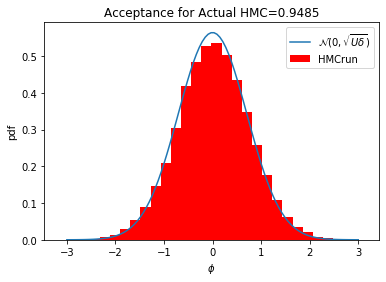

In [11]:
import scipy.stats as stats
x = np.linspace(-3, 3, 100)
plt.title("Acceptance for Actual HMC={}".format(act_prob.mean())) 
plt.hist(np.array(actual).flatten(), density=True, bins=30,label='HMCrun',color='r') 
plt.plot(x, stats.norm.pdf(x, 0, usqrt),label=r'$\mathcal{N}(0,\sqrt{U\delta})$')
plt.ylabel('pdf')
plt.xlabel(r'$\phi$')
plt.legend(loc='best')
#plt.savefig("acceptance_{}.pdf".format(NNg_prob.mean()))
# g_all = np.array(g_all)
# pp_all = np.array(pp_all)
# print(g_all.shape,pp_all.shape)
# fig,ax = plt.subplots(1,3,figsize=(15,10),sharex=True)
# aax = ax[0]
# aax.set_title("Gradients of proposed Phi")
# for i in range(g_all.shape[0]):
#     aax.plot(np.arange(g_all.shape[1]),g_all[i][:])

# aax = ax[1]
# aax.set_title("Proposed Phi")
# for i in range(pp_all.shape[0]):
#     aax.plot(np.arange(pp_all.shape[1]),pp_all[i][:])
    
# aax = ax[2]
# aax.set_title("Actual Phi")
# for i in range(np.array(actual).shape[0]):
#     aax.plot(np.arange(np.array(actual).shape[1]),actual[i][:])

In [46]:
# Generate training data
num_samples = 1000
training_data = np.zeros((num_samples,Nt*Nx))
gradient = np.zeros((num_samples,Nt*Nx))
for i in range(num_samples): 
    training_data[i,:] = np.random.normal(0,usqrt,Nt*Nx)
    gradient[i,:] = gradS(training_data[i,:],U*delta,Nt)

# print(training_data.shape)
# print(gradient.shape)
    


In [60]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


scaled_data = preprocessing.StandardScaler().fit(training_data)
#training_data = preprocessing.scale(training_data)
# X_train = training_data
# y_train = gradient
# X_test = training_data
# y_test = gradient

X_train, X_test, y_train, y_test = train_test_split(training_data, gradient, test_size=0.20)




In [95]:
# Train the NN to approximate gradient
%reload_ext autoreload

#%autoreload 2
from models import exper, build

epoch = 2500
batch = 34
model = exper(32, [64,64,64,64] , 32)
#model = build(32,[64],[32])

r = model.fit(training_data,gradient,epochs=epoch, batch_size=batch,verbose=0)

#r = model.fit(X_train, y_train,validation_data=(X_test,y_test),epochs=epoch, batch_size=batch,verbose=0)


loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f'% (accuracy*100), 'Loss: %.2f' % (loss))

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_265 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_266 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_267 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_268 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_269 (Dense)            (None, 32)                2080      
Total params: 16,672
Trainable params: 16,672
Non-trainable params: 0
_________________________________________________________________
7/7 [==============================] - ETA: 0s - loss: 2.1185 - accuracy: 0.43 - 0s 0s/step - loss: 1.9359 - accura

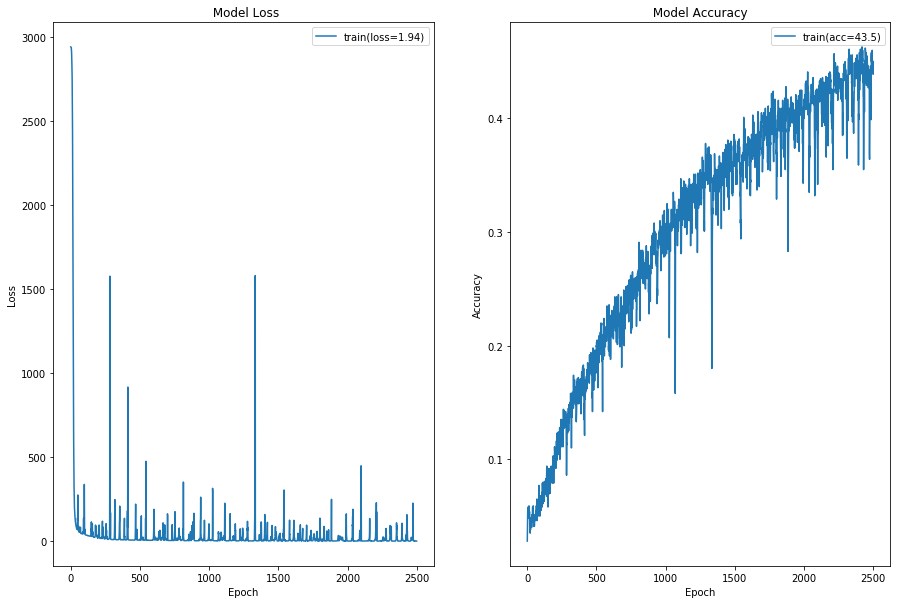

In [97]:


## Loss and Accuracy plots

fig,ax = plt.subplots(1,2,figsize=(15,10),sharex=True)
axx = ax[0]
axx.set_title(" Model Loss")
axx.set_ylabel("Loss")
axx.set_xlabel("Epoch")
axx.plot(r.history['loss'],label='train(loss={})'.format(np.round(loss,2)))
#axx.plot(r.history['val_loss'],label='validation')
axx.legend()

axx = ax[1]
axx.set_title(" Model Accuracy ")
axx.set_ylabel("Accuracy")
axx.set_xlabel("Epoch")
axx.plot(r.history['accuracy'],label='train(acc={})'.format(np.round((accuracy*100),2)))
#axx.plot(r.history['val_accuracy'],label = 'validation')
axx.legend()


#plt.savefig("Loss_Acc_plot.pdf")

In [100]:
from surrogate import NeuralGrad

#Using the NN inside HMC to sample points
grad_hat = NeuralGrad(model,scaled_data)
NNg ,NNg_prob,g_NN,pp_NN = HMC(surrogate = grad_hat)

print("act_prob=",act_prob.mean())
print("NNg_prob=",NNg_prob.mean())


act_prob= 0.9485
NNg_prob= 0.69


In [102]:

k = np.where(act_prob == 1.0)
c= np.where(NNg_prob == 1.0)
print(c[0].shape,k[0].shape)


(1380,) (1897,)


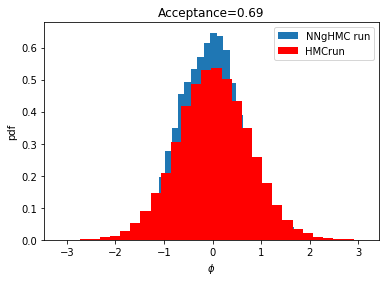

In [114]:
import scipy.stats as stats
flattend = np.array(NNg).flatten()
x = np.linspace(-3, 3, 100)
plt.title("Acceptance={}".format(NNg_prob.mean()))
plt.hist(flattend, density=True, bins=30,label='NNgHMC run')  
plt.hist(np.array(actual).flatten(), density=True, bins=30,label='HMCrun',color='r') 
#plt.plot(x, stats.norm.pdf(x, 0, usqrt),label=r'$\mathcal{N}(0,\sqrt{U\delta})$')
plt.ylabel('pdf')
plt.xlabel(r'$\phi$')
plt.legend(loc='best')
plt.savefig("acceptance_{}.pdf".format(NNg_prob.mean()))

In [115]:
print("NNg mean",flattend.mean())
print("Actual HMC mean",np.array(actual).flatten().mean())

NNg mean -0.030199278271128133
Actual HMC mean 0.018954104872181778


In [105]:
exactData = open("U2B4.dat").readlines()
exT = []
exBonding = []
exAntiBonding = []
exAA = []
exAB = []
exBA = []
exBB = []
for i in range(len(exactData)):
    split = exactData[i].split()
    exT.append(float(split[0]))   # tau
    exAntiBonding.append(float(split[1]))  # anti-bonding
    exBonding.append(float(split[2]))      # bonding
    exAA.append(float(split[3]))  # cAA
    exAB.append(float(split[4]))  # cAB
    exBA.append(float(split[5]))  # cBA
    exBB.append(float(split[6]))  # cBB

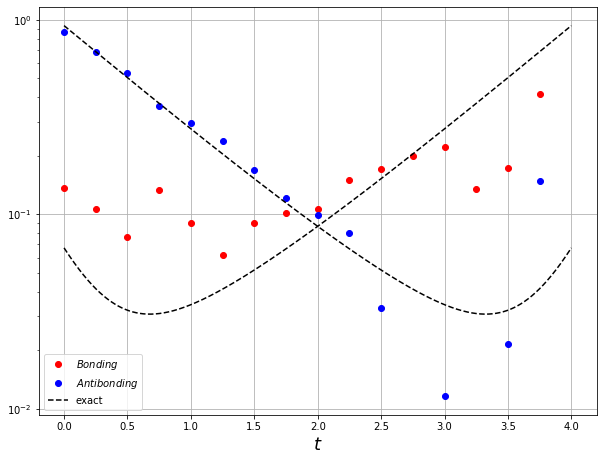

In [108]:
corrUp_b = [ [] for t in range(Nt)] # <===== each correlator has Nt elements
corrUp_ab = [ [] for t in range(Nt)]
Cxx = [ [] for t in range(Nt)]
Cxy = [ [] for t in range(Nt)]
Cyx = [ [] for t in range(Nt)]
Cyy = [ [] for t in range(Nt)]

nTherm = 200

### calculate the bonding/anti-bonding correlator
for i in range(nTherm,nTrajs):
    # arrow up correlator
    phi = NNg[i]
    Mphi(phi,expk,Nt)
    invMUp = np.linalg.inv(M)
    
    # we now construct the correlators
    # bonding correlator is .5*(Cxx+Cxy+Cyx+Cyy)
    # antibonding is .5*(Cxx-Cxy-Cyx+Cyy)
    for t in range(Nt):
        corrUp_b[t].append(np.real(.5*(invMUp[t*Nx+0][0*Nx+0]+invMUp[t*Nx+0][0*Nx+1]+
                               invMUp[t*Nx+1][0*Nx+0]+invMUp[t*Nx+1][0*Nx+1])))
        corrUp_ab[t].append(np.real(.5*(invMUp[t*Nx+0][0*Nx+0]-invMUp[t*Nx+0][0*Nx+1]-
                               invMUp[t*Nx+1][0*Nx+0]+invMUp[t*Nx+1][0*Nx+1])))
        Cxx[t].append(np.real(invMUp[t*Nx+0][0*Nx+0]))
        Cxy[t].append(np.real(invMUp[t*Nx+0][0*Nx+1]))
        Cyx[t].append(np.real(invMUp[t*Nx+1][0*Nx+0]))
        Cyy[t].append(np.real(invMUp[t*Nx+1][0*Nx+1]))

# here I set up arrays that store the averages
corrBond = []
corrAntiBond = []

# ok, I'm mixing up naming conventions.  Here 'A' = 'x' and 'B' = 'y'
cAA = []
cAB = []
cBA = []
cBB = []

# now I calculate the averages for each timeslice
for t in range(Nt):
    corrBond.append(np.mean(corrUp_b[t]))
    corrAntiBond.append(np.mean(corrUp_ab[t]))
    cAA.append(np.mean(Cxx[t]))
    cAB.append(np.mean(Cxy[t]))
    cBA.append(np.mean(Cyx[t]))
    cBB.append(np.mean(Cyy[t]))
        
tau = np.linspace(0,beta-beta/Nt,Nt) # <===== this is the correct distancing for tau

plt.subplots(1,1,figsize=(10,7.5))
plt.plot(tau,corrBond,'ro',label= r'$Bonding$')
plt.plot(tau,corrAntiBond,'bo', label = '$Antibonding$')
plt.plot(exT,exBonding,'k--',label='exact')
plt.plot(exT,exAntiBonding,'k--')
plt.grid()
plt.xlabel(r'$t$',fontsize=18)
plt.yscale('log')
plt.legend(loc='best')
plt.savefig("co-relator_{}.pdf".format(NNg_prob.mean()))

In [ ]:
print("NNg prob",NNg_prob.mean(),NNg_prob)
g_NN = np.array(g_NN)
pp_NN = np.array(pp_NN)
print(g_NN.shape,pp_NN.shape)

fig,ax = plt.subplots(1,3,figsize=(15,10),sharex=True)
aax = ax[0]
aax.set_title("NNg Gradients of proposed Phi")
for i in range(g_NN.shape[0]):
    aax.plot(np.arange(g_NN.shape[1]),g_NN[i][:])

aax = ax[1]
aax.set_title("Proposed Phi")
for i in range(pp_NN.shape[0]):
    aax.plot(np.arange(pp_NN.shape[1]),pp_NN[i][:])
    
aax = ax[2]
aax.set_title("Actual Phi")
for i in range(np.array(NNg).shape[0]):
    aax.plot(np.arange(np.array(NNg).shape[1]),NNg[i][:])